
#Práctico División Dataset

##Sistemas Recomendadores: IIC3633-1

**Profesor**: Denis Parra

**Ayudantes**:
*   Alejandro Plaza
*   Daniel Sebastian
*   Pablo Messina
*   Carlos Muñoz


---



In [21]:
!pip install pyreclab --upgrade

In [22]:
!pip install psutil

In [23]:
!pip install implicit

### 1. División de Datasets en RecSys

**Objetivos**
Al finalizar esta práctica, el estudiante será capaz de:

1.   Comprender la importancia del split de datos en sistemas de recomendación
2.   Implementar diferentes técnicas de división de datasets

**Descripción General**
En esta práctica abordaremos uno de los aspectos fundamentales en el desarrollo de sistemas de recomendación: la división adecuada de los datasets para entrenamiento y test. A diferencia de otros problemas de machine learning, los sistemas de recomendación requieren consideraciones especiales al momento de dividir los datos debido a la naturaleza temporal y relacional de las interacciones usuario-ítem.

En este práctico exploraremos dos enfoques fundamentales para la división de datos: la división no temporal (non-temporal split) y la división temporal (temporal split). La primera técnica se centra en distribuir aleatoriamente las interacciones usuario-ítem, útil cuando la secuencia temporal no es crítica para las predicciones. Por otro lado, la división temporal preserva el orden cronológico de las interacciones, simulando escenarios más realistas donde el comportamiento pasado influye en las recomendaciones futuras.

Es importante señalar que estos métodos pueden adaptarse y combinarse según los objetivos específicos de sus proyectos, considerando factores como la densidad de los datos, el problema cold-start, etc.


#### 1.1. **No temporal Split**: Cuando no tenemos o disponemos de timestamp o marcas de tiempo.

In [24]:
import pandas as pd
import pyreclab
import numpy as np
import scipy.sparse as sparse
import implicit
import psutil
import time
from sklearn.model_selection import train_test_split

%matplotlib inline

In [25]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [3]:
# Dataset: https://drive.google.com/drive/folders/1hnGjZk-a4-GLjsKN0NzAaDZlRu2SPuye?usp=drive_link
!gdown "1BMUg0hR5LdUN3pmvwZR9qj9KTXYdBHu_"

Downloading...
From: https://drive.google.com/uc?id=1BMUg0hR5LdUN3pmvwZR9qj9KTXYdBHu_
To: /content/tarea_1.csv
100% 887k/887k [00:00<00:00, 110MB/s]


In [26]:
file =  pd.read_csv('tarea_1.csv')
print(file.head(5))
print('-'*100)
file.info()

   userID  itemID  styleID  rating
0     401   32780    12224     3.0
1    7548   21688     9020     3.5
2    7663    1521      568     4.0
3    1357    3824     1417     3.5
4    1361     727      263     4.5
----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44379 entries, 0 to 44378
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   userID   44379 non-null  int64  
 1   itemID   44379 non-null  int64  
 2   styleID  44379 non-null  int64  
 3   rating   44379 non-null  float64
dtypes: float64(1), int64(3)
memory usage: 1.4 MB


In [27]:
train_indices = []
test_indices = []

grouped = file.groupby('userID')
min_ratings = 5 # Considera solo aquellos usuarios que han tenido al menos 5 valoraciones.

for user_id, group in grouped:
    if len(group) > min_ratings:
        # Se hace un split del 20% de las calificaciones del usuario
        train_idx, test_idx = train_test_split(group.index, test_size=0.2, random_state=42)

        train_indices.extend(train_idx)
        test_indices.extend(test_idx)
    else:
        # Si el usuario tiene menos rating de los que definimos como mínimo, lo dejamos en train (no en test)
        train_indices.extend(group.index)


train = file.loc[train_indices]
test = file.loc[test_indices]

# Verificar las proporciones
print(f"Train set size: {len(train)} ({len(train)/len(file):.2%})")
print(f"Test set size: {len(test)} ({len(test)/len(file):.2%})")

Train set size: 37152 (83.72%)
Test set size: 7227 (16.28%)


In [28]:
num_users_train = train['userID'].nunique()
num_users_test = test['userID'].nunique()

print(f"Number of distinct users in the trainset: {num_users_train}")
print(f"Number of distinct users in the testset: {num_users_test}")

Number of distinct users in the trainset: 8320
Number of distinct users in the testset: 1792




---

##### 1.1.1. ¿Es posible que existan usuarios en el conjunto de test que no estén presentes en el conjunto de entrenamiento? Valide esta situación y comente el motivo.

In [29]:
users_train = train['userID'].unique()
users_test  = test['userID'].unique()

In [30]:
unique_values = set(users_test) - set(users_train)

if unique_values:
    print(f"Values in list1 but not in list2: {unique_values}")
else:
    print("All values from list1 are also in list2.")

All values from list1 are also in list2.


---

##### 1.1.2. ¿Es posible que existan ítems en el conjunto de test que no estén presentes en el conjunto de entrenamiento? Valide esta situación y comente el motivo.

In [31]:
items_train = train['itemID'].unique()
items_test  = test['itemID'].unique()

In [32]:
unique_values = set(items_test) - set(items_train)

if unique_values:
    print(f"Values in list1 but not in list2: {unique_values}")
else:
    print("All values from list1 are also in list2.")

Values in list1 but not in list2: {74753, 75267, 1546, 23563, 30222, 27664, 23568, 27666, 9239, 73752, 20504, 73241, 73769, 37930, 35386, 30780, 26686, 71231, 58942, 62531, 40004, 20038, 73290, 73291, 36943, 59984, 22609, 65103, 56404, 63066, 55905, 46179, 62056, 23660, 29296, 70770, 72820, 52859, 36484, 52869, 38540, 73357, 44686, 53907, 41116, 41130, 37045, 52405, 37559, 40629, 31426, 74946, 19140, 36035, 36038, 76999, 75984, 75989, 73941, 27861, 76505, 51931, 38619, 73950, 40672, 54497, 17124, 67813, 36580, 20199, 24296, 64745, 23793, 37619, 50421, 21751, 69373, 36609, 21762, 68867, 69386, 28433, 33043, 49941, 75030, 75031, 26394, 43803, 26909, 49949, 50980, 48932, 55076, 9511, 15656, 26420, 74556, 25405, 21824, 72009, 66889, 34636, 57686, 42330, 33116, 62820, 34153, 71533, 56687, 66932, 11638, 70009, 43920, 10645, 56733, 49571, 48549, 64423, 61864, 43945, 73129, 53678, 34738, 66484, 19895, 28096, 27585, 72130, 26562, 54724, 59849, 39886, 62441, 47596, 71157, 36348}


In [33]:
test = test[~test['itemID'].isin(unique_values)].reset_index(drop=True)



---

##### 1.1.3. ¿Cómo se distribuye el consumo de ítems en cada división del conjunto de datos (train y test)?

Realizar un análisis preliminar es crucial para entender en detalle cómo se han llevado a cabo las divisiones del conjunto de datos.

In [34]:
train_grouped = train.groupby('userID')['userID'].count().sort_values(ascending=False)
train_grouped.head(len(train_grouped))

,userID
userID,
13,144
24,103
490,92
100,88
695,84
...,...
5147,1
1969,1
5151,1


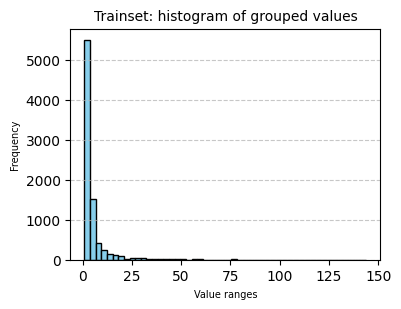

In [35]:
import pandas as pd
import matplotlib.pyplot as plt

# Crear un histograma
plt.figure(figsize=(4, 3))
plt.hist(train_grouped, bins=50, color='skyblue', edgecolor='black')

plt.title("Trainset: histogram of grouped values", fontsize=10)
plt.xlabel("Value ranges", fontsize=7)
plt.ylabel("Frequency", fontsize=7)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

In [36]:
test_grouped = test.groupby('userID')['userID'].count().sort_values(ascending=False)
test_grouped.head(len(test_grouped))

,userID
userID,
13,35
24,26
490,22
695,21
139,20
...,...
839,1
3335,1
8193,1


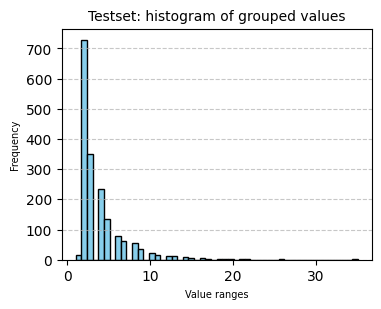

In [37]:
import pandas as pd
import matplotlib.pyplot as plt

# Crear un histograma
plt.figure(figsize=(4, 3))
plt.hist(test_grouped, bins=50, color='skyblue', edgecolor='black')

plt.title("Testset: histogram of grouped values", fontsize=10)
plt.xlabel("Value ranges", fontsize=7)
plt.ylabel("Frequency", fontsize=7)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()



---



Es importante recordar que, para cada nuevo conjunto de datos, se recomienda realizar un análisis descriptivo que permita evaluar la calidad de los datos y determinar el nivel de limpieza necesario. Después de este análisis y del correspondiente preprocesamiento, se sugiere proceder con la división del conjunto de datos (split).

El alcance de este práctico no incluye la realización de análisis descriptivo ni el preprocesamiento de los datos.

###### Finalmente, almacena las divisiones generadas.

In [38]:
train_shuffled = train.sample(frac=1, random_state=42).reset_index(drop=True)
test_shuffled = test.sample(frac=1, random_state=42).reset_index(drop=True)

train_shuffled.to_csv('training_set.csv', index=False)
test_shuffled.to_csv('test_set.csv', index=False)

In [39]:
item_style_df = file[['itemID', 'styleID']].drop_duplicates()
item_style_df.to_csv('items_styles.csv', index=False)

#### 1.2. **Temporal split**: división basada en timestamps.

Para esta sección tomaremos como ejemplo el dataset de **Movielens**, lo pueden encontrar en el siguiente [link](https://files.grouplens.org/datasets/movielens/ml-100k/u.data).

In [40]:
!pip install recommenders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.4/316.4 kB 10.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 12.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 356.0/356.0 kB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.0/82.0 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 53.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 83.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.0/261.0 kB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 88.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━

In [41]:
from recommenders.datasets.python_splitters import (
    python_random_split,
    python_chrono_split,
    python_stratified_split
)

from datetime import datetime, timedelta

In [42]:
filepath = "https://files.grouplens.org/datasets/movielens/ml-100k/u.data"

dataset = pd.read_csv(filepath, sep="\t", names=["UserId", "MovieId", "Rating", "Timestamp"])
dataset.head(3)

,UserId,MovieId,Rating,Timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116


In [43]:
print("Total number of ratings are\t{}".format(dataset.shape[0]),
      "Total number of users are\t{}".format(dataset["UserId"].nunique()),
      "Total number of items are\t{}".format(dataset["MovieId"].nunique()),
      sep="\n")

Total number of ratings are	100000
Total number of users are	943
Total number of items are	1682


In [44]:
dataset["Timestamp"]= dataset.apply(
    lambda x: datetime.strftime(datetime(1970, 1, 1, 0, 0, 0) + timedelta(seconds=x["Timestamp"].item()), "%Y-%m-%d %H:%M:%S"),
    axis=1)

In [45]:
dataset.head(3)

,UserId,MovieId,Rating,Timestamp
0,196,242,3,1997-12-04 15:55:49
1,186,302,3,1998-04-04 19:22:22
2,22,377,1,1997-11-07 07:18:36




---


##### 1.2.1. ¿Qué usuario tiene el menor consumo de películas? ¿Es necesario aplicar un filtro de usuarios, como se hizo en la pregunta 1.1? Justifique su respuesta.

In [46]:
grouped = dataset.groupby('UserId')['UserId'].count().sort_values(ascending=False)

In [47]:
grouped

,UserId
UserId,
405,737
655,685
13,636
450,540
276,518
...,...
685,20
475,20
36,20




---



La división cronológica se lleva a cabo utilizando las marcas de tiempo y los usuarios, asignando el 70 % de los datos al conjunto de entrenamiento y el 30 % restante al conjunto de test. Esta separación se realiza tomando como referencia las marcas de tiempo de los registros en el conjunto de datos.

In [48]:
trainset, testset = python_chrono_split(dataset, ratio=0.7, filter_by="user",
                                        col_user="UserId", col_item="MovieId", col_timestamp="Timestamp")

In [49]:
trainset.head(5)

,UserId,MovieId,Rating,Timestamp
59972,1,168,5,1997-09-22 21:57:58
92487,1,172,5,1997-09-22 21:57:58
74577,1,165,5,1997-09-22 21:58:38
48214,1,156,4,1997-09-22 21:59:16
15764,1,196,5,1997-09-22 22:01:17


In [50]:
testset.head(5)

,UserId,MovieId,Rating,Timestamp
5682,1,49,3,1997-11-03 07:34:38
24493,1,30,3,1997-11-03 07:35:15
6234,1,233,2,1997-11-03 07:35:52
39865,1,131,1,1997-11-03 07:35:52
4280,1,82,5,1997-11-03 07:36:29




---


##### 1.2.2. ¿Cuál es la fecha de corte en el conjunto de entrenamiento y la fecha de inicio en el conjunto de test para un usuario específico? ¿A qué cree que se debe este comportamiento? Justifique su respuesta.

In [51]:
user_id = 1

In [52]:
print("min trainset\t{}".format(min(trainset[trainset["UserId"]==user_id]['Timestamp'])),
      "max trainset\t{}".format(max(trainset[trainset["UserId"]==user_id]['Timestamp'])),
      sep="\n")

min trainset	1997-09-22 21:57:58
max trainset	1997-11-03 07:34:19


In [54]:
print("min testset\t{}".format(min(testset[testset["UserId"]==user_id]['Timestamp'])),
      "max testset\t{}".format(max(testset[testset["UserId"]==user_id]['Timestamp'])),
      sep="\n")

min testset	1997-11-03 07:34:38
max testset	1998-03-13 01:15:36


In [55]:
user_id = 800

In [56]:
print("min trainset\t{}".format(min(trainset[trainset["UserId"]==user_id]['Timestamp'])),
      "max trainset\t{}".format(max(trainset[trainset["UserId"]==user_id]['Timestamp'])),
      sep="\n")

min trainset	1998-02-16 16:19:30
max trainset	1998-02-16 16:36:19


In [57]:
print("min testset\t{}".format(min(testset[testset["UserId"]==user_id]['Timestamp'])),
      "max testset\t{}".format(max(testset[testset["UserId"]==user_id]['Timestamp'])),
      sep="\n")

min testset	1998-02-16 16:36:20
max testset	1998-02-16 16:36:20




---



##### 1.2.3. ¿En qué situaciones es crucial separar el conjunto de datos en función del tiempo? Justifique su respuesta.

**Respuesta**: Es crucial en problemas donde la recomendación depende de secuencias, ya que la temporalidad y el orden de las interacciones juegan un papel fundamental para capturar patrones relevantes y ofrecer buenas predicciones.



---



**Referencias**:

*   https://github.com/recommenders-team/recommenders/tree/main


